In [448]:
#%%
import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy.optimize import approx_fprime
from matplotlib import pyplot as plt
#%%
'''
    mx: mean of source with size: n x 1
    M: means of target distributions with size: n x K, where K indicates number of data-classes.
    covx: covariance matrix of source with size: n x 1
    covM: array of covariance matrices of target distributions with size: K x n x n, where K indicates number of data-classes.
    max_iter: max_iterations of Frank Wolfe
    tol: tolerance for gradient check
    divg: divergences to be used for computations
    max_iter: maximum of frank wolfe iterations
    min_tol: minimum tolerance for gardient checking
    print_iter: priniting values of maixture weights for each iteration
'''
class GM_FW:
    def __init__(self, mux, M, covx, covM, c0,  max_iter = None, min_tol = None, print_iter = None):
        # instance attributes which should be initilzied with class
        self.mux = mux
        self.M = M
        self.covx = covx
        self.covM = covM
        self.c0 = c0
        self.divg = divg
        
        self.sqrt_covx = sp.linalg.sqrtm(covx)
        print(self.sqrt_covx.shape)
        self.I = np.identity(np.size(mux))

        # attributes to be keep track of computations
        self.c = np.zeros_like(c0)
        self.mubar = np.zeros_like(mux)
        self.hat_covM = self.covM + self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]) @ self.M.T.reshape([M.shape[1], 1, M.shape[0]])
        self.tilde_covM = np.zeros_like(covM)
        self.tilde_sigma_c = np.zeros([covM.shape[1], covM.shape[2]])
        self.zeta_c = np.zeros([covM.shape[1], covM.shape[2]])
        
        if max_iter == None:
            self.max_iter = 1000
        else:
            self.max_iter = max_iter

        if min_tol == None:
            self.min_tol = 1e-6
        else:
            self.min_tol = min_tol
        
        if print_iter == None:
            self.print_iter = False
        elif print_iter == False:
            self.print_iter = False
        elif print_iter == True:
            self.print_iter = True
        else:
            self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])
    
    def reset_values(self):
        # self.mux = mux
        # self.M = M
        # self.covx = covx
        # self.covM = covM
        # self.c0 = c0
        # self.divg = divg

        self.sqrt_covx = sp.linalg.sqrtm(self.covx)
        self.I = np.identity(np.size(self.mux))

        # attributes to be keep track of computations
        self.c = np.zeros_like(self.c0)
        self.mubar = np.zeros_like(self.mux)
        self.hat_covM = self.covM + \
            self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]
                        ) @ self.M.T.reshape([self.M.shape[1], 1, self.M.shape[0]])
        self.tilde_covM = np.zeros_like(self.covM)
        self.tilde_sigma_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])
        self.zeta_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])

        # if max_iter == None:
        #     self.max_iter = 1000
        # else:
        #     self.max_iter = max_iter

        # if min_tol == None:
        #     self.min_tol = 1e-6
        # else:
        #     self.min_tol = min_tol

        # if print_iter == None:
        #     self.print_iter = False
        # elif print_iter == False:
        #     self.print_iter = False
        # elif print_iter == True:
        #     self.print_iter = True
        # else:
        #     self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])

    def initialize_weights(self):
        self.c = self.c0

    def compute_mubar(self):
        self.mubar =  np.sum(self.c[np.newaxis,:] * self.M, axis = 1, keepdims = True)
    
    def compute_mmd(self):
        return np.linalg.norm(self.mux - self.M@self.c)**2
    
    def compute_mmd_grad(self):
        return 2*self.M.T @ (self.M @ self.c[:,np.newaxis] - self.mux)

    def compute_tilde_covM(self):
        self.tilde_covM = self.hat_covM - (self.mubar@self.mubar.T)[np.newaxis,:,:]

        
    def compute_tilde_sigma_c(self):
        self.tilde_sigma_c = np.sum(
            self.c[:, np.newaxis, np.newaxis] * self.tilde_covM, axis=0)
            
    def compute_zeta_c(self):
        temp = sp.linalg.sqrtm(self.sqrt_covx @ self.tilde_sigma_c @ self.sqrt_covx)
        self.zeta_c = (temp + temp.T)/2

    def compute_bures(self):
        temp =  np.trace( self.covx + self.tilde_sigma_c - 2 * self.zeta_c )
        return temp
    
    def compute_bures_grad_tilde_sigma_c(self):
        return self.I - self.sqrt_covx @ sp.linalg.pinv(self.zeta_c) @ self.sqrt_covx
    
    def compute_bures_grad_c(self):
        G = self.compute_bures_grad_tilde_sigma_c()
        rho = (self.M.T.reshape(self.M.shape[1], self.M.shape[0],1) @ mubar.T) + mubar @ self.M.T.reshape(self.M.shape[1],1,self. M.shape[0])
        temp = np.sum(G[np.newaxis, :, :] * (self.hat_covM - rho ), axis=(1, 2))
        return temp
    
    def FW_Bures_routine(self):

        # commented part must be uncommented for gradient-checking
        def bures(c_i):
            mubar =  np.sum(c_i[np.newaxis,:] * self.M, axis = 1, keepdims = True)
            tilde_covM = self.hat_covM - (mubar@mubar.T)[np.newaxis,:,:]
            
            tilde_sigma_c = np.sum(c_i[:, np.newaxis, np.newaxis] * tilde_covM, axis=0)
            zeta_ci = sp.linalg.sqrtm(self.sqrt_covx @ tilde_sigma_c @ self.sqrt_covx)
            temp =  np.trace( tilde_sigma_c + self.covx  - 2 * zeta_ci )
            return temp
        
        def bures_grad(c_i):
            mubar =  np.sum(c_i[np.newaxis,:] * self.M, axis = 1, keepdims = True)
            #print("mubar")
            #print(mubar)
            #print("hat_covM")
            #print(self.hat_covM )
            #print("tilde_covM")
            tilde_covM = self.hat_covM - (mubar@mubar.T)[np.newaxis,:,:]
            #print(tilde_covM)
            tilde_sigma_c = np.sum(c_i[:, np.newaxis, np.newaxis] * tilde_covM, axis=0)
            #print("tilde_sigma_c")
            #print(tilde_sigma_c)
            temp = sp.linalg.sqrtm(self.sqrt_covx @ tilde_sigma_c @ self.sqrt_covx)
            zeta_ci = (temp + temp.T)/2
            #print("sqrt_covx")
            #print(self.sqrt_covx)
            #print("zeta_ci")
            #print(zeta_ci)
            G = self.I - self.sqrt_covx @ np.linalg.pinv(zeta_ci) @ self.sqrt_covx
            print("G")
            print(G)
            rho = (M.T.reshape(M.shape[1],M.shape[0],1) @ mubar.T) +  mubar @ M.T.reshape(M.shape[1],1,M.shape[0])
            print("rho")
            print(rho)
            return np.sum(G[np.newaxis, :, :] * (hat_covM - rho ), axis=(1, 2))
            

        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.compute_mubar()
            self.compute_tilde_covM()
            self.compute_tilde_sigma_c()
            self.compute_zeta_c()
            self.compute_bures_grad_c()
            self.obj_vals[i] = self.compute_bures()
            g = self.compute_bures_grad_c()
            
            print("g")
            c_i = self.c
            
            print(np.squeeze(bures_grad(c_i)))
            #print(np.squeeze(self.compute_bures_grad_c()))

            eps = np.sqrt(np.finfo(float).eps)/100
            ga = sp.optimize.approx_fprime(c_i, bures, np.array([eps ,eps, eps]).T)
            print("ga")
            print(ga)
            
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s
            self.grads[i, :] = np.squeeze(g)
            self.weights[i, :] = self.c

    def FW_MMD_routine(self):
        
        # commented part must be uncommented for gradient-checking
        
        def mmd(c_i):

            return (np.linalg.norm(self.M@c_i[:,np.newaxis] - self.mux))**2
        def mmd_grad(c_i):
            return np.squeeze(2 * self.M.T @ (self.M @ c_i[:,np.newaxis] - self.mux))
        
        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.compute_mubar()
            self.compute_tilde_covM()
            self.obj_vals[i] = self.compute_mmd()

            g = self.compute_mmd_grad()

            print("g")
            c_i = self.c
            print(np.squeeze(mmd_grad(c_i)))
            #print(np.squeeze(self.compute_mmd_grad()))

            eps = np.sqrt(np.finfo(float).eps) * 100
            
            print("ga")
            ga = sp.optimize.approx_fprime(c_i, mmd, np.array([eps ,eps, eps]).T)
            print(ga)

            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c  + gamma * s 
            self.grads[i,:] = np.squeeze(g)
            self.weights[i,:] = self.c


$\beta$

In [466]:
import numpy as np
import scipy as sp

M = np.array([[0, -0.5, 0.5],[1, 0, 0]])
mux = np.array([[np.sqrt(3)/2], [np.sqrt(3)/2] ])
covx = np.array([[10,6],[6,8]])
covM = np.zeros([3,2,2])
covM[0] = np.array([[1, 0.5],[0.5, 1]])
covM[1] = np.array([[5, 0.6], [0.7, 7]])
covM[2] = np.array([[4, 1], [1, 2]])
divg = "MMD"
c0 = np.ones(3)/3

iterations = 3

test = GM_FW(mux, M, covx, covM, c0, max_iter = iterations)
#test.FW_MMD_routine()


(2, 2)


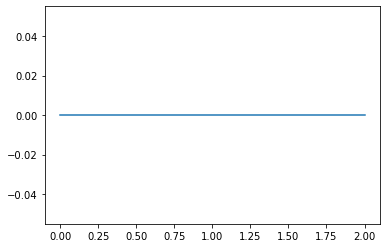

In [467]:
iters = np.arange(0,test.grads.shape[0])
plt.plot(iters, test.obj_vals)

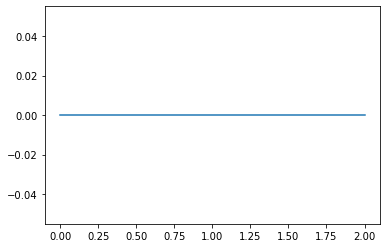

In [468]:
iters = np.arange(0, test.grads.shape[0])
plt.plot(iters, np.linalg.norm(test.grads, axis = 1))

In [469]:
test.reset_values()
test.FW_Bures_routine()

g
G
[[-0.55001141 -0.42588768]
 [-0.42588768 -0.35596637]]
rho
[[[ 0.          0.        ]
  [ 0.          0.66666667]]

 [[ 0.         -0.16666667]
  [-0.16666667  0.        ]]

 [[ 0.          0.16666667]
  [ 0.16666667  0.        ]]]
[-1.45052092 -6.07494105 -3.75929405]
ga
[-1.41099691 -6.03568554 -3.71977091]
g
G
[[-0.29218607 -0.38028847]
 [-0.38028847  0.01511999]]
rho
[[[ 0.  -0.5]
  [-0.5  0. ]]

 [[ 0.5  0. ]
  [ 0.   0. ]]

 [[-0.5  0. ]
  [ 0.   0. ]]]
[-1.02252302 -1.77641889 -2.11822078]
ga
[-0.94945431 -1.70358419 -2.04504728]
g
G
[[-0.29218607 -0.38028847]
 [-0.38028847  0.01511999]]
rho
[[[ 0.  -0.5]
  [-0.5  0. ]]

 [[ 0.5  0. ]
  [ 0.   0. ]]

 [[-0.5  0. ]
  [ 0.   0. ]]]
[-1.02252302 -1.77641889 -2.11822078]
ga
[-0.94945431 -1.70358419 -2.04504728]


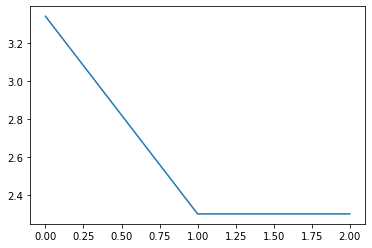

In [470]:
iters = np.arange(0, test.grads.shape[0])
plt.plot(iters, test.obj_vals)


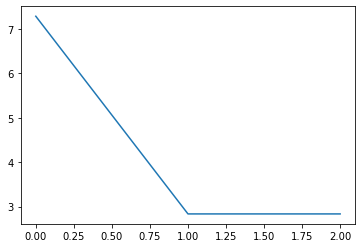

In [471]:
iters = np.arange(0, test.grads.shape[0])
plt.plot(iters, np.linalg.norm(test.grads, axis=1))


In [472]:
test.c

array([0., 1., 0.])

In [456]:
tilde_covM = hat_covM - (mubar@mubar.T)[np.newaxis,:,:]
print(tilde_covM)

[[[1.         0.5       ]
  [0.5        1.88888889]]

 [[5.25       0.6       ]
  [0.7        6.88888889]]

 [[4.25       1.        ]
  [1.         1.88888889]]]


In [457]:
tilde_sigma_c = c0[:, np.newaxis, np.newaxis] * tilde_covM
print(tilde_sigma_c)
tilde_sigma_c = np.sum(c0[:, np.newaxis, np.newaxis] * tilde_covM, axis = 0)
print(tilde_sigma_c)

[[[0.33333333 0.16666667]
  [0.16666667 0.62962963]]

 [[1.75       0.2       ]
  [0.23333333 2.2962963 ]]

 [[1.41666667 0.33333333]
  [0.33333333 0.62962963]]]
[[3.5        0.7       ]
 [0.73333333 3.55555556]]


In [458]:
tilde_sigma_c = np.sum(tilde_covM, axis = 0)
print(tilde_sigma_c/3)

[[3.5        0.7       ]
 [0.73333333 3.55555556]]


In [459]:
test.grads.shape

(3, 3)

In [238]:
M

array([[ 0. , -0.5,  0.5],
       [ 1. ,  0. ,  0. ]])

In [239]:
M[:,0].shape

(2,)

In [249]:
M

array([[ 0. , -0.5,  0.5],
       [ 1. ,  0. ,  0. ]])

In [270]:
M[:,np.newaxis,1] @ M[:,np.newaxis,1].T

array([[0.25, 0.  ],
       [0.  , 0.  ]])

In [271]:
M[:,np.newaxis,1] 

array([[-0.5],
       [ 0. ]])

In [352]:
(M.T.reshape(M.shape[1],M.shape[0],1) @ mubar.T) 

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.33333333]],

       [[ 0.        , -0.16666667],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.16666667],
        [ 0.        ,  0.        ]]])

In [332]:
 mubar @ M.T.reshape(M.shape[1],1,M.shape[0])

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.33333333]],

       [[ 0.        ,  0.        ],
        [-0.16666667,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.16666667,  0.        ]]])

In [333]:
mubar

array([[0.        ],
       [0.33333333]])

In [314]:
M.T.reshape(3,2,1) @ mubar.T.shape

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [308]:
mubar @ M.T.reshape(3,2,1).T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [309]:
mubar.shape

(2, 1)

In [311]:
M.T.shape

(3, 2)

In [447]:
test.c

array([0., 1., 0.])

NameError: name 'self' is not defined